# Agent-Based Model using Mesa
Coding bi-polarization model from Mäs & Flache (2013)

In [1]:
!pip install mesa

In [1]:
import mesa
import pandas as pd
import random
import statistics
from matplotlib import pyplot as plt

ABM Code

This model replicates the Mäs and Flache (2013) model on opinion bipolarization. 
We initiate each agent with an opinion of zero (same number of pro and con arguments in their relevant argument vector)
It also only chooses one random agent per step, as only one pairwise interaction should take place per timestep t.

In [277]:
# in this first version, all agents start with an opinion of value 0

In [180]:
def compute_bipol(model):
    N = model.num_agents
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    
    std_opinion = statistics.stdev(agent_opinions)
    return std_opinion

def getOpinions(model):
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    return agent_opinions
    
class OpinionAgent(mesa.Agent):
    """An agent with S arguments, an opinion and two interaction processes."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        arg_array_pro = [] # create argument vector with all P and C elements and their value of +1 and -1 
        arg_array_con = []
        for i in range(1,model.proarg+1):
            arg_array_pro.append([i,1])
            arg_array_con.append([i+model.proarg,-1])
        arg_array = 
        r_array_pro = [] # add 0 or 1 to each argument in the argument array, to initiate a relevant-argument vector for each agent i
        r_array_con = []
        for i in range(len(arg_array_pro)):
            if i< (model.relevantArgs/2):
                r_array_pro.append(1)
                r_array_con.append(1)
            else:
                r_array_pro.append(0)
                r_array_con.append(0)
        random.shuffle(r_array_pro)
        random.shuffle(r_array_con)
        
        
        for i in range(len(r_array_pro)):
            arg_array_pro[i].append(r_array_pro[i])
            arg_array_con[i].append(r_array_con[i])
        
        arg_array = arg_array_pro + arg_array_con
        
        
        opinion_array = []
        for arg in arg_array:
            opinion_array.append([arg[0]]) # keep argument id in the opinion array
        for i,arg in enumerate(arg_array):
            opinion_array[i].append(arg[1]*arg[2])
           
        opinion_vector = [arg for arg in opinion_array if arg[1] != 0]  # make shortened opinion vector, only keeping relevant opinions
        opinion_values_vector = [arg[1] for arg in opinion_vector]
        opinion = (sum(opinion_values_vector))/model.relevantArgs # this is the agent's opinion o(i,t) that is between -1 and 1

        for i in range(len(opinion_vector)):
            opinion_vector[i].append(i+1)  # add the recency variable; we initialize this with values 1 through S
        self.opinion = opinion
        self.opinion_vector = opinion_vector
        
    def interaction(self): # first part of interaction is partner selection phase
     
        # first stage is partner selection
        sim_lst = [] # list of relative similarity of chosen agent i with each of the other agents created
        agent_lst = [agent for agent in model.schedule.agents if agent != self]
        print(len(agent_lst))
        for i, agent in enumerate(agent_lst):
            sim_ij = 0.5*(2-abs(self.opinion - agent.opinion))
            sim_lst.append(sim_ij)
                  
        p_lst = []
        sum_p = sum([(sim**model.homophily) for sim in sim_lst])
        for i, sim in enumerate(sim_lst):
            p = (sim**model.homophily) / sum_p
            p_lst.append(p)
        
        agent_j = random.choices(agent_lst, weights=p_lst, k=1)[0] # pick random interaction partner with weights equivalent to the probabilities based on homophily
        # make sure we don't choose the same agent for the interaction
        same_agent = False
        if agent_j == self:
            same_agent = True
            while same_agent == True:
                agent_j = random.choices(model.schedule.agents, weights=p_lst, k=1)[0]
                if agent_j == self:
                    same_agent = True
                else:
                    same_agent = False
        
        
        # second stage is interaction
        chosen_arg = self.random.choice(agent_j.opinion_vector) # the first value is the argument (either -1 or +1), while the second value indicates recency of arg for agent j, which is not interesting at this point
        
        # before we add this argument to agent i's argument vector, need to check if agent i already knows this argument
        knows_arg = False
        for i in range(len(self.opinion_vector)):
            if self.opinion_vector[i][0] == chosen_arg[0]:
                knows_arg = True
                idx_arg = i
            else:
                pass
            
        # now append if agent i does not know this argument
        if knows_arg == False:
            chosen_arg[2] = model.relevantArgs+1
            self.opinion_vector.append(chosen_arg) # append new argument with recency of S+1 to opinion vector of agent i
            for i in range(len(self.opinion_vector)):
                self.opinion_vector[i][2] = (self.opinion_vector[i][2])-1 # reduce recency of each argument by 1
            self.opinion_vector.pop(0)
        
        # only update recency of arguments if agent i already knows the argument
        if knows_arg == True:
            arg_recency = self.opinion_vector[idx_arg][2]  
            self.opinion_vector.pop(idx_arg)
            chosen_arg[2] = model.relevantArgs+1
            
            self.opinion_vector.append(chosen_arg)            
            for i in range(len(self.opinion_vector)): # now reduce recency of every argument with recency larger than communicated arg's recency
                if self.opinion_vector[i][2] > arg_recency:
                    self.opinion_vector[i][2] = (self.opinion_vector[i][2])-1
        
        # after updating agent i's opinion vector, we are updating their opinion
        self.opinion_values_vector = [arg[1] for arg in self.opinion_vector]
       
        self.opinion = (sum(self.opinion_values_vector))/model.relevantArgs
       
    
class OpinionModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, h, P, C, r):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        self.homophily = h # specify parameter h, indicating level of homophily
        self.proarg = P # number of Pro arguments
        self.conarg = C # number of Con arguments
        self.relevantArgs = r
        self.running = True

        # Create agents
        self.agent_lst = []
        for i in range(self.num_agents):
            a = OpinionAgent(i, self)
            
            self.agent_lst.append(a)
            self.schedule.add(a)

        self.datacollector = mesa.DataCollector(
            model_reporters={"Bipolarization": compute_bipol, "Opinions": getOpinions} #agent_reporters={"Opinion": "opinion"} )
        )
    def step(self):
        chosen_agent = random.choice(self.agent_lst)
        # after inspecting intermediate steps in the model, it seems that after this step.
        # for some reason, the recency values get messed up, so we fix them again here
        for i, arg in enumerate(chosen_agent.opinion_vector):
            if arg[2] != i+1:
                arg[2] = i+1
        chosen_agent.interaction()
        self.datacollector.collect(self)

In [ ]:
# the second model version is below, with opinions initiated by randomly choosing arguments for each agent

In [202]:
def compute_bipol(model):
    N = model.num_agents
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    
    std_opinion = statistics.stdev(agent_opinions)
    return std_opinion

def getOpinions(model):
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    return agent_opinions
    
class OpinionAgent(mesa.Agent):
    """An agent with S arguments, an opinion and two interaction processes."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        arg_array_pro = [] # create argument vector with all P and C elements and their value of +1 and -1 
        arg_array_con = []
        for i in range(1,model.proarg+1):
            arg_array_pro.append([i,1])
            arg_array_con.append([i+model.proarg,-1])
        arg_array = arg_array_pro + arg_array_con
        # shuffle the whole argument array
        arg_array = random.sample(arg_array, len(arg_array))
        # now pick S random arguments from the argument array
        opinion_vector = random.sample(arg_array, model.relevantArgs)

        opinion_values_vector = [arg[1] for arg in opinion_vector]
        opinion = (sum(opinion_values_vector))/model.relevantArgs # this is the agent's opinion o(i,t) that is between -1 and 1

        for i in range(len(opinion_vector)):
            opinion_vector[i].append(i+1)  # add the recency variable; we initialize this with values 1 through S
        self.opinion = opinion
        self.opinion_vector = opinion_vector
        
    def interaction(self): # first part of interaction is partner selection phase
     
        # first stage is partner selection
        sim_lst = [] # list of relative similarity of chosen agent i with each of the other agents created
        agent_lst = [agent for agent in model.schedule.agents if agent != self]
        for i, agent in enumerate(agent_lst):
            sim_ij = 0.5*(2-abs(self.opinion - agent.opinion))
            sim_lst.append(sim_ij)
                  
        p_lst = []
        sum_p = sum([(sim**model.homophily) for sim in sim_lst])
        for i, sim in enumerate(sim_lst):
            p = (sim**model.homophily) / sum_p
            p_lst.append(p)
        
        agent_j = random.choices(agent_lst, weights=p_lst, k=1)[0] # pick random interaction partner with weights equivalent to the probabilities based on homophily
        # make sure we don't choose the same agent for the interaction
        same_agent = False
        if agent_j == self:
            same_agent = True
            while same_agent == True:
                agent_j = random.choices(model.schedule.agents, weights=p_lst, k=1)[0]
                if agent_j == self:
                    same_agent = True
                else:
                    same_agent = False
        
        
        # second stage is interaction
        chosen_arg = self.random.choice(agent_j.opinion_vector) # the first value is the argument (either -1 or +1), while the second value indicates recency of arg for agent j, which is not interesting at this point
        
        # before we add this argument to agent i's argument vector, need to check if agent i already knows this argument
        knows_arg = False
        for i in range(len(self.opinion_vector)):
            if self.opinion_vector[i][0] == chosen_arg[0]:
                knows_arg = True
                idx_arg = i
            else:
                pass
            
        # now append if agent i does not know this argument
        if knows_arg == False:
            chosen_arg[2] = model.relevantArgs+1
            self.opinion_vector.append(chosen_arg) # append new argument with recency of S+1 to opinion vector of agent i
            for i in range(len(self.opinion_vector)):
                self.opinion_vector[i][2] = (self.opinion_vector[i][2])-1 # reduce recency of each argument by 1
            self.opinion_vector.pop(0)
        
        # only update recency of arguments if agent i already knows the argument
        if knows_arg == True:
            arg_recency = self.opinion_vector[idx_arg][2]  
            self.opinion_vector.pop(idx_arg)
            chosen_arg[2] = model.relevantArgs+1
            
            self.opinion_vector.append(chosen_arg)            
            for i in range(len(self.opinion_vector)): # now reduce recency of every argument with recency larger than communicated arg's recency
                if self.opinion_vector[i][2] > arg_recency:
                    self.opinion_vector[i][2] = (self.opinion_vector[i][2])-1
        
        # after updating agent i's opinion vector, we are updating their opinion
        self.opinion_values_vector = [arg[1] for arg in self.opinion_vector]
       
        self.opinion = (sum(self.opinion_values_vector))/model.relevantArgs
       
    
class OpinionModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, h, P, C, r):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        self.homophily = h # specify parameter h, indicating level of homophily
        self.proarg = P # number of Pro arguments
        self.conarg = C # number of Con arguments
        self.relevantArgs = r
        self.running = True

        # Create agents
        self.agent_lst = []
        for i in range(self.num_agents):
            a = OpinionAgent(i, self)
            self.agent_lst.append(a)
            self.schedule.add(a)

        self.datacollector = mesa.DataCollector(
            model_reporters={"Bipolarization": compute_bipol, "Opinions": getOpinions} #agent_reporters={"Opinion": "opinion"} )
        )
    def step(self):
        chosen_agent = random.choice(self.agent_lst)
        # after inspecting intermediate steps in the model, it seems that after this step.
        # for some reason, the recency values get messed up, so we fix them again here
        for i, arg in enumerate(chosen_agent.opinion_vector):
            if arg[2] != i+1:
                arg[2] = i+1
        chosen_agent.interaction()
        self.datacollector.collect(self)

The third model version is initiated with a uniform opinion distribution. This model version is used in the paper in section 1.3.4 where a large number of simulations is run and parameter h is changed we use this third model version to run the simulation.

In [252]:
def compute_bipol(model):
    N = model.num_agents
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    
    std_opinion = statistics.stdev(agent_opinions)
    return std_opinion

def getOpinions(model):
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    return agent_opinions
    
class OpinionAgent(mesa.Agent):
    """An agent with S arguments, an opinion and two interaction processes."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        arg_array_pro = [] # create argument vector with all P and C elements and their value of +1 and -1 
        arg_array_con = []
        for i in range(1,model.proarg+1):
            arg_array_pro.append([i,1])
            arg_array_con.append([i+model.proarg,-1])
        # shuffle each array, we will make random draws from these later, based on the opinion value selected
        arg_array_pro = random.sample(arg_array_pro, len(arg_array_pro))
        arg_array_con = random.sample(arg_array_con, len(arg_array_con))
        # we have S+1 possible opinions to draw from
        # to ensure uniform distribution of opinions at the start, we make random draws from this list
        S_plus1_lst = list(range(model.relevantArgs+1))   
        
        # make random draw from this list
        random_op_val = random.choice(S_plus1_lst)
        # make random draws from pro and con argument vectors based on this number
        # e.g., if we drew 0, we draw 0 random pro arguments and S random con arguments; and so on.
        opinion_vector_pro = random.sample(arg_array_pro, random_op_val)
        opinion_vector_con = random.sample(arg_array_con, (model.relevantArgs-random_op_val))  
        opinion_vector = opinion_vector_pro + opinion_vector_con
        
        opinion_values_vector = [arg[1] for arg in opinion_vector]
        opinion = (sum(opinion_values_vector))/model.relevantArgs # this is the agent's opinion o(i,t) that is between -1 and 1

        for i in range(len(opinion_vector)):
            opinion_vector[i].append(i+1)  # add the recency variable; we initialize this with values 1 through S
        self.opinion = opinion
        self.opinion_vector = opinion_vector
        
    def interaction(self): # first part of interaction is partner selection phase
     
        # first stage is partner selection
        sim_lst = [] # list of relative similarity of chosen agent i with each of the other agents created
        agent_lst = [agent for agent in model.schedule.agents if agent != self]
        for i, agent in enumerate(agent_lst):
            sim_ij = 0.5*(2-abs(self.opinion - agent.opinion))
            sim_lst.append(sim_ij)
                  
        p_lst = []
        sum_p = sum([(sim**model.homophily) for sim in sim_lst])
        for i, sim in enumerate(sim_lst):
            p = (sim**model.homophily) / sum_p
            p_lst.append(p)
        
        agent_j = random.choices(agent_lst, weights=p_lst, k=1)[0] # pick random interaction partner with weights equivalent to the probabilities based on homophily
        # make sure we don't choose the same agent for the interaction
        same_agent = False
        if agent_j == self:
            same_agent = True
            while same_agent == True:
                agent_j = random.choices(model.schedule.agents, weights=p_lst, k=1)[0]
                if agent_j == self:
                    same_agent = True
                else:
                    same_agent = False
        
        
        # second stage is interaction
        chosen_arg = self.random.choice(agent_j.opinion_vector) # the first value is the argument (either -1 or +1), while the second value indicates recency of arg for agent j, which is not interesting at this point
        
        # before we add this argument to agent i's argument vector, need to check if agent i already knows this argument
        knows_arg = False
        for i in range(len(self.opinion_vector)):
            if self.opinion_vector[i][0] == chosen_arg[0]:
                knows_arg = True
                idx_arg = i
            else:
                pass
            
        # now append if agent i does not know this argument
        if knows_arg == False:
            chosen_arg[2] = model.relevantArgs+1
            self.opinion_vector.append(chosen_arg) # append new argument with recency of S+1 to opinion vector of agent i
            for i in range(len(self.opinion_vector)):
                self.opinion_vector[i][2] = (self.opinion_vector[i][2])-1 # reduce recency of each argument by 1
            self.opinion_vector.pop(0)
        
        # only update recency of arguments if agent i already knows the argument
        if knows_arg == True:
            arg_recency = self.opinion_vector[idx_arg][2]  
            self.opinion_vector.pop(idx_arg)
            chosen_arg[2] = model.relevantArgs+1
            
            self.opinion_vector.append(chosen_arg)            
            for i in range(len(self.opinion_vector)): # now reduce recency of every argument with recency larger than communicated arg's recency
                if self.opinion_vector[i][2] > arg_recency:
                    self.opinion_vector[i][2] = (self.opinion_vector[i][2])-1
        
        # after updating agent i's opinion vector, we are updating their opinion
        self.opinion_values_vector = [arg[1] for arg in self.opinion_vector]
       
        self.opinion = (sum(self.opinion_values_vector))/model.relevantArgs
       
    
class OpinionModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, h, P, C, r):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        self.homophily = h # specify parameter h, indicating level of homophily
        self.proarg = P # number of Pro arguments
        self.conarg = C # number of Con arguments
        self.relevantArgs = r
        self.running = True

        # Create agents
        self.agent_lst = []
        
        for i in range(self.num_agents):
            a = OpinionAgent(i, self)
            self.agent_lst.append(a)
            self.schedule.add(a)
        self.datacollector = mesa.DataCollector(
            model_reporters={"Bipolarization": compute_bipol, "Opinions": getOpinions} #agent_reporters={"Opinion": "opinion"} )
        )
    def step(self):
        chosen_agent = random.choice(self.agent_lst)
        # after inspecting intermediate steps in the model, it seems that after this step.
        # for some reason, the recency values get messed up, so we fix them again here
        for i, arg in enumerate(chosen_agent.opinion_vector):
            if arg[2] != i+1:
                arg[2] = i+1
        chosen_agent.interaction()
        self.datacollector.collect(self)

In [ ]:
# conduct a trial model run with h= 9

In [256]:
model = OpinionModel(N = 100, h = 9, P = 30, C= 30, r = 10)
for i in range(30000):
    model.step()

In [257]:
bipolarization = model.datacollector.get_model_vars_dataframe()["Bipolarization"]
opinions = model.datacollector.get_model_vars_dataframe()["Opinions"]

<AxesSubplot:>

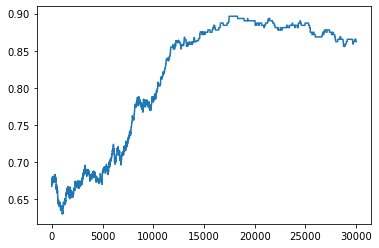

In [258]:
bipolarization.plot()

In [259]:
avg_opinion = []
for opinion in opinions:
    avg = sum(opinion)/len(opinion)
    avg_opinion.append(avg)

<AxesSubplot:>

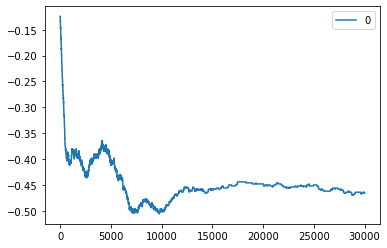

In [260]:
df_opinion = pd.DataFrame(avg_opinion)
df_opinion.plot()

Now, conduct several simulation runs for h=8 and h=0, each running 100 times

In [261]:
bipolarization_lst_high_h = []
opinions_lst_high_h = []
for i in range(100):
    model = OpinionModel(N = 20, h = 8, P = 20, C= 20, r = 6)
    for i in range(30000):
        model.step()
    bipolarization = model.datacollector.get_model_vars_dataframe()["Bipolarization"]
    opinions = model.datacollector.get_model_vars_dataframe()["Opinions"]
    bipolarization_lst_high_h.append(bipolarization)
    opinions_lst_high_h.append(opinions)

In [262]:
bipolarization_lst_low_h = []
opinions_lst_low_h = []
for i in range(100):
    model = OpinionModel(N = 20, h = 0, P = 20, C= 20, r = 6)
    for i in range(30000):
        model.step()
    bipolarization = model.datacollector.get_model_vars_dataframe()["Bipolarization"]
    opinions = model.datacollector.get_model_vars_dataframe()["Opinions"]
    bipolarization_lst_low_h.append(bipolarization)
    opinions_lst_low_h.append(opinions)

<AxesSubplot:>

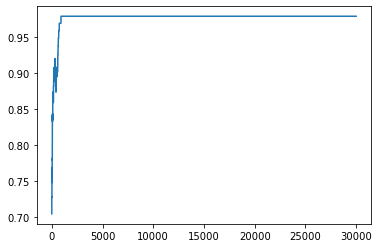

In [266]:
# plot one sample outcome from the simulation with h=8
bipolarization_lst_high_h[5].plot()

<AxesSubplot:>

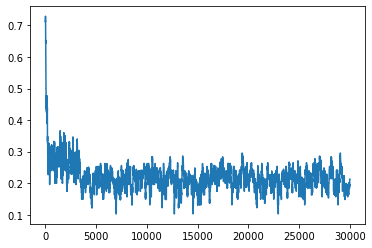

In [278]:
# plot one sample outcome from the simulation with h=0
bipolarization_lst_low_h[5].plot()

In [269]:
# take average value of bipolarization at each event t across the 100 repetitions
bipolarization_high_h_avg = [sum(x)/len(x) for x in zip(*bipolarization_lst_high_h)]

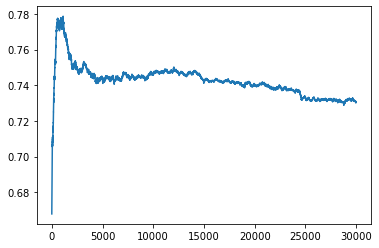

In [270]:
# plot the average result
plt.plot(bipolarization_high_h_avg)

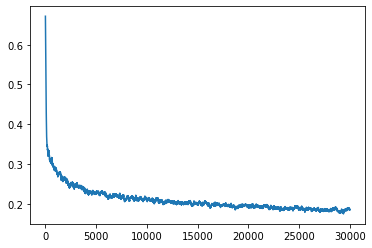

In [265]:
# now do the same for h = 0
bipolarization_low_h_avg = [sum(x)/len(x) for x in zip(*bipolarization_lst_low_h)]
plt.plot(bipolarization_low_h_avg)

In [279]:
# count number of group splits (we define those as bipolarization >= 0.8) for both simulations
bip_end_high_h = []

for bip in bipolarization_lst_high_h:
    bip_end_high_h.append(bip[29999])

bip_end_low_h = [] 
for bip in bipolarization_lst_low_h:
    bip_end_low_h.append(bip[29999])

count_splits = 0
for i, value in enumerate(bip_end_high_h):
    if value >= 0.8:
        count_splits+=1
        idx = i
split_ratio_high_h = count_splits/len(bip_end_high_h)

count_splits = 0
for value in bip_end_low_h:
    if value >= 0.8:
        count_splits+=1
split_ratio_low_h = count_splits/len(bip_end_low_h)

In [280]:
print("Share of group splits with high homophily: " + str(split_ratio_high_h) + 
      " , Share of group splits with low homophily: " + str(split_ratio_low_h))

Share of group splits with high homophily: 0.65 , Share of group splits with low homophily: 0.0
